In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold


In [2]:
# This is an array of ground truth density profiles of halos. 
# It is an MxN matrix where M is the number of radial bins and N in is the number of halos.
# For example, truth[:, i] gives you the density profile for halo i and 
# truth[j] gives you the distribution of rho in radial bin j for all halos.

truth = np.load("../../true_log_rho_per_radial_bin_sim11_testset.npy")
truth.shape

(13, 4332)

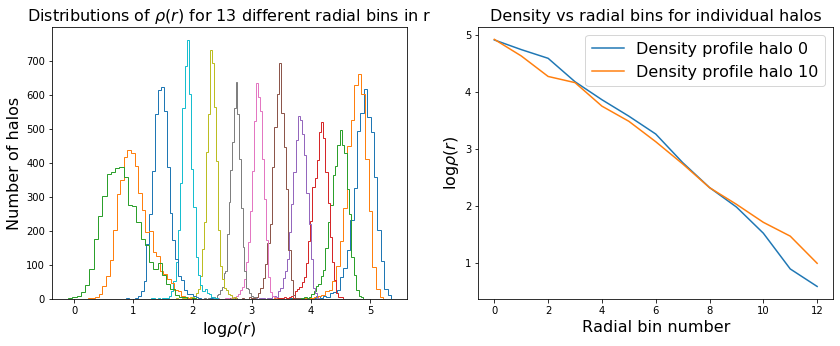

In [3]:
r_bins = truth.shape[0]
f, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_xlabel(r"$\log \rho(r)$", fontsize=16)
axes[0].set_ylabel("Number of halos", fontsize=16)
for i in range(r_bins):
    _ = axes[0].hist(truth[i], bins=30, histtype="step")
axes[0].set_title(rf"Distributions of $\rho(r)$ for {r_bins} different radial bins in r", fontsize=16)

axes[1].plot(truth[:,0], label="Density profile halo 0")
axes[1].plot(truth[:,10], label="Density profile halo 10")
axes[1].set_ylabel(r"$\log \rho(r)$", fontsize=16)
axes[1].set_xlabel("Radial bin number", fontsize=16)
axes[1].legend(loc="best", fontsize=16)
axes[1].set_title("Density vs radial bins for individual halos", fontsize=16);

In [8]:
# Each halo has 3 associated Gaussian latent distributions. These are means and standard deviations of the latents.
# lmean and lstd are MxN arrays where M is the number of halos and N is the number of latents (3 in this case).
# For example, lmean[0], lstd[0] give you the means and standard deviations of the 3 latent distributions for halos 0.
# lmean[:, 0], lstd[:, 0] give you the mean and standard deviations for all halos for latent 0.

epoch = 27

lmean, lstd = np.load(f"../../latent_mean_11_testset_epoch_{epoch}.npy"), np.load(f"../../latent_std_11_testset_epoch_{epoch}.npy")

In [9]:
# To obtain the distribution of latents from the set of means/std-devs, one has to sample from each Gaussian
# e.g. to sample from latent 0, you can do (the second should be faster, but equivalent):
#samples = np.random.multivariate_normal(lmean[:, 0], np.diag(lstd[:, 0])**2, 1).reshape(len(lmean[:,0]))
latent_var = 0
samples = np.random.default_rng(42).normal(lmean[:, latent_var], lstd[:, latent_var], len(lmean[:, latent_var]))

# Note that this is the mixture distribution of each latent, i.e. this is e.g. p(z0) = int p(z0|x)p(x)dx, 
# where each p(z0|x) is a gaussian distribution. This explains why the distribution of samples is not
# necessarily a gaussian distribution

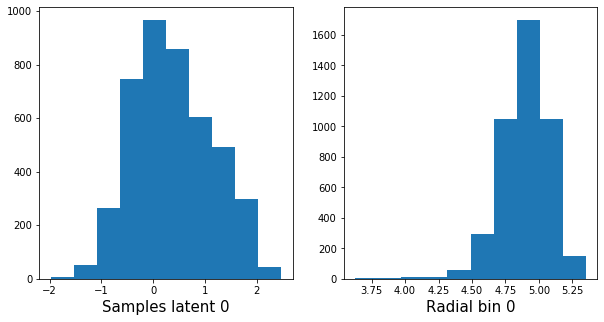

In [10]:
# Just some plots to show some distributions of interest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples)
ax1.set_xlabel('Samples latent 0', fontsize=15);
ax2.hist(truth[0])
ax2.set_xlabel('Radial bin 0', fontsize=15);

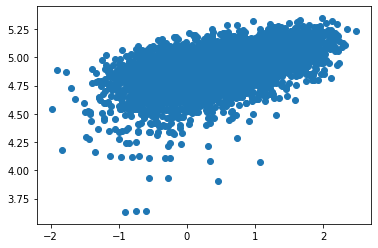

In [11]:
X = np.stack((samples, truth[0]), axis=0).T
plt.scatter(X[:, 0], X[:, 1]);

### MINE estimator from https://github.com/gtegner/mine-pytorch

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
from datasets import MultivariateNormalDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)
dim = 1

from sklearn.model_selection import train_test_split

Device: cpu
cpu


In [28]:
dim = 1
N = X.shape[0]
train_size = int(0.9 * N)
test_size = N - train_size
lr = 1e-3
epochs = 500
batch_size = 512

loss_type = ['fdiv']  # mine, mine_biased, fdiv
loss = loss_type[0]

train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

#train_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
    
kwargs = {
    'lr': lr,
    'batch_size': batch_size,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'alpha': 1.0
}

model = MutualInformationEstimator(
    dim, dim, loss=loss, **kwargs).to(device)

In [29]:
trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
trainer.fit(model)
trainer.test()

#print("True_mi {}".format(true_mi))
print("MINE {}".format(model.avg_test_mi))
#results.append((rho, model.avg_test_mi, true_mi))

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.30batch/s]
MINE 0.1754874885082245


0.16543158888816833, 0.16563725471496582 (diff lr),  0.19776636362075806 (more epochs), 0.17688453197479248 (even more epochs), 0.19828101992607117 (501 instead of 500 epochs), 0.16360683739185333 (32 instead of 512 bs), 0.19304132461547852 (mine_biased), 0.1754874885082245 (fdiv)

In [ ]:
# same for another pair, maybe one where the value is found correctly (and still high)

In [30]:
# To obtain the distribution of latents from the set of means/std-devs, one has to sample from each Gaussian
# e.g. to sample from latent 0, you can do (the second should be faster, but equivalent):
#samples = np.random.multivariate_normal(lmean[:, 0], np.diag(lstd[:, 0])**2, 1).reshape(len(lmean[:,0]))
latent_var = 1
samples = np.random.default_rng(42).normal(lmean[:, latent_var], lstd[:, latent_var], len(lmean[:, latent_var]))

# Note that this is the mixture distribution of each latent, i.e. this is e.g. p(z0) = int p(z0|x)p(x)dx, 
# where each p(z0|x) is a gaussian distribution. This explains why the distribution of samples is not
# necessarily a gaussian distribution

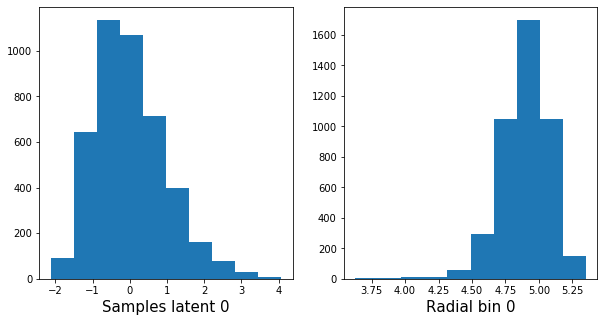

In [31]:
# Just some plots to show some distributions of interest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples)
ax1.set_xlabel('Samples latent 0', fontsize=15);
ax2.hist(truth[0])
ax2.set_xlabel('Radial bin 0', fontsize=15);

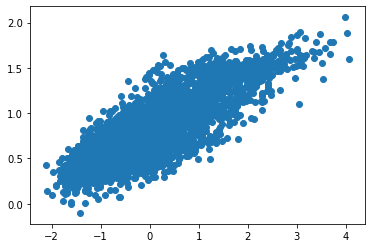

In [32]:
X = np.stack((samples, truth[-1]), axis=0).T
plt.scatter(X[:, 0], X[:, 1]);

### MINE estimator from https://github.com/gtegner/mine-pytorch

In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader

from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
from datasets import MultivariateNormalDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)
dim = 1

from sklearn.model_selection import train_test_split

cpu


In [48]:
dim = 1
N = X.shape[0]
train_size = int(0.9 * N)
test_size = N - train_size
lr = 1e-3
epochs = 500
batch_size = 32

loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

#train_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
    
kwargs = {
    'lr': lr,
    'batch_size': batch_size,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'alpha': 1.0
}

model = MutualInformationEstimator(
    dim, dim, loss=loss, **kwargs).to(device)

In [49]:
trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
trainer.fit(model)
trainer.test()

#print("True_mi {}".format(true_mi))
print("MINE {}".format(model.avg_test_mi))
#results.append((rho, model.avg_test_mi, true_mi))

Testing: 100%|██████████| 122/122 [00:00<00:00, 461.48batch/s]
MINE 0.547181248664856


0.5470867156982422, 0.5546563267707825 (diff lr), 0.5773555040359497 (more epochs), 0.5357617735862732 (even more epochs) 0.51703941822052 (501 instead of 500 epochs), 0.547181248664856 (32 instead of 512 bs), 0.5739040970802307 (mine_biased), 0.566737711429596 (fdiv)

### Now let's do it for all latents and bins

In [51]:
total_time = time.time()
samples = np.random.default_rng(42).normal(lmean[:, 0], lstd[:, 0], len(lmean[:, 0]))

In [52]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial = []
for radbin in range(r_bins):
    X = np.stack((samples, truth[radbin]), axis=0).T

    dim = 1
    N = X.shape[0]
    lr = 1e-3
    epochs = 500
    batch_size = 512

    loss_type = ['mine']  #mine_biased, fdiv
    loss = loss_type[0]

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)

    initial_time = time.time()
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    
    trainer.fit(model)
    trainer.test()

    print("MINE {}".format(model.avg_test_mi))
    
    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial.append(model.avg_test_mi)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

Testing: 100%|██████████| 8/8 [00:00<00:00, 119.27batch/s]
MINE 0.16843342781066895
Total time to run the procedure: 106.70 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 110.95batch/s]
MINE 0.19257783889770508
Total time to run the procedure: 103.49 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 111.56batch/s]
MINE 0.22148656845092773
Total time to run the procedure: 103.99 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.10batch/s]
MINE 0.29217565059661865
Total time to run the procedure: 102.88 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 111.99batch/s]
MINE 0.30198919773101807
Total time to run the procedure: 103.63 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 121.00batch/s]
MINE 0.313984751701355
Total time to run the procedure: 105.83 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 121.94batch/s]
MINE 0.27570977807044983
Total time to run the procedure: 104.79 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 118.51batch/s]
MINE 0.1841977834701538
Total time to run the procedur

In [53]:
MI_radial = np.array(MI_radial)

In [54]:
MI_radial = np.reshape(MI_radial, (-1, 1))

In [56]:
#np.save('./MI_halo_latent0_MINE.npy', MI_radial)

In [57]:
MI_radial_mine = np.load('./MI_halo_latent0_MINE.npy')

In [61]:
MI_radial = np.load('../../haloes_MI_latent0_newproc.npy')
MI_radial_one = np.load('../../haloes_MI_latent1_newproc.npy')
MI_radial_two = np.load('../../haloes_MI_latent2_newproc.npy')

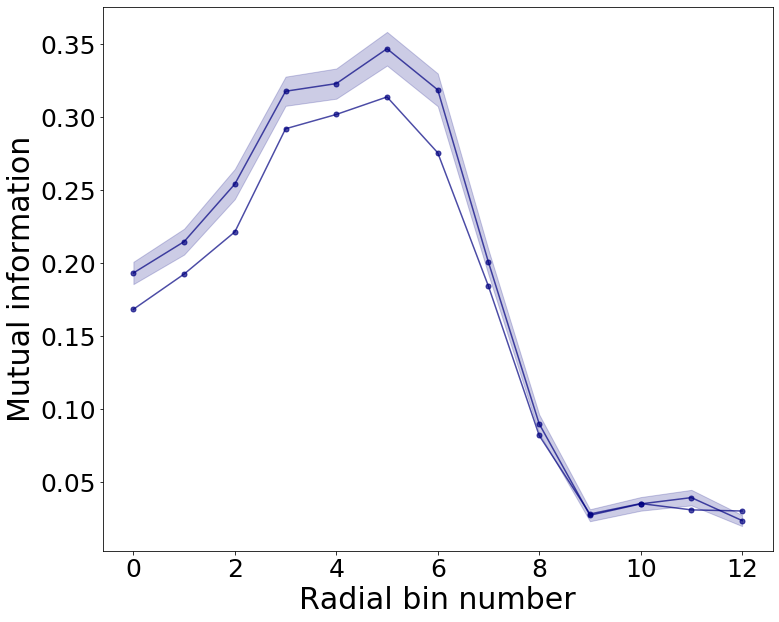

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(r_bins), np.mean(MI_radial, axis=1), color='navy', marker='o', markersize=5, alpha=0.7)
ax.fill_between(np.arange(r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+ np.std(MI_radial, axis=1), color='navy', alpha=0.2)

ax.plot(np.arange(r_bins), np.mean(MI_radial_mine, axis=1), color='navy', marker='o', markersize=5, alpha=0.7)

ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel('Mutual information', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25);

In [65]:
total_time = time.time()
samples_one = np.random.normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))

In [66]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial_one = []
for radbin in range(r_bins):
    X = np.stack((samples_one, truth[radbin]), axis=0).T

    dim = 1
    N = X.shape[0]
    lr = 1e-3
    epochs = 500
    batch_size = 512

    loss_type = ['mine']  #mine_biased, fdiv
    loss = loss_type[0]

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)

    initial_time = time.time()
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    
    trainer.fit(model)
    trainer.test()

    print("MINE {}".format(model.avg_test_mi))
    
    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_one.append(model.avg_test_mi)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

Testing: 100%|██████████| 8/8 [00:00<00:00, 119.95batch/s]
MINE 0.01808801293373108
Total time to run the procedure: 105.98 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 119.81batch/s]
MINE 0.014841914176940918
Total time to run the procedure: 103.27 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 110.93batch/s]
MINE 0.017754167318344116
Total time to run the procedure: 102.23 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 112.37batch/s]
MINE 0.010208964347839355
Total time to run the procedure: 105.81 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 112.40batch/s]
MINE 0.023460596799850464
Total time to run the procedure: 106.17 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 121.55batch/s]
MINE 0.020048409700393677
Total time to run the procedure: 102.38 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 119.87batch/s]
MINE 0.025463342666625977
Total time to run the procedure: 101.71 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 122.55batch/s]
MINE 0.022617220878601074
Total time to run th

In [67]:
total_time = time.time()
samples_two = np.random.normal(lmean[:, 2], lstd[:, 2], len(lmean[:, 2]))

In [68]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

MI_radial_two = []
for radbin in range(r_bins):
    X = np.stack((samples_two, truth[radbin]), axis=0).T

    dim = 1
    N = X.shape[0]
    lr = 1e-3
    epochs = 500
    batch_size = 512

    loss_type = ['mine']  #mine_biased, fdiv
    loss = loss_type[0]

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)

    initial_time = time.time()
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    
    trainer.fit(model)
    trainer.test()

    print("MINE {}".format(model.avg_test_mi))
    
    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    MI_radial_two.append(model.avg_test_mi)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.16batch/s]
MINE 0.012394040822982788
Total time to run the procedure: 103.69 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 122.40batch/s]
MINE 0.017724692821502686
Total time to run the procedure: 102.51 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 117.38batch/s]
MINE 0.03574615716934204
Total time to run the procedure: 102.47 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.13batch/s]
MINE 0.04141978919506073
Total time to run the procedure: 102.47 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 111.87batch/s]
MINE 0.023824542760849
Total time to run the procedure: 107.47 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.85batch/s]
MINE 0.014893442392349243
Total time to run the procedure: 104.82 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 121.54batch/s]
MINE 0.012026757001876831
Total time to run the procedure: 101.70 s

Testing: 100%|██████████| 8/8 [00:00<00:00, 120.05batch/s]
MINE 0.0310521237552166
Total time to run the proc

In [93]:
# let's look at the trend for this latent and all the radial bins
# we use a simple way to stop adding components, only for the sake of this argument

#MI_radial_two = []
for radbin in range(12, 13):
    X = np.stack((samples_two, truth[radbin]), axis=0).T

    dim = 1
    N = X.shape[0]
    lr = 1e-3
    epochs = 200
    batch_size = 512

    loss_type = ['mine']  #mine_biased, fdiv
    loss = loss_type[0]

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=45)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)

    initial_time = time.time()
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    
    trainer.fit(model)
    trainer.test()

    print("MINE {}".format(model.avg_test_mi))
    
    print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
    print()
    #MI_radial_two.append(model.avg_test_mi)
    
print(f'Total time to make 1/3 of the plot: {time.time()-total_time:.2f} s')

Testing: 100%|██████████| 8/8 [00:00<00:00, 121.00batch/s]
MINE 0.035623885691165924
Total time to run the procedure: 42.42 s

Total time to make 1/3 of the plot: 7026.73 s


In [85]:
MI_radial_mine_two

array([[0.01239404],
       [0.01772469],
       [0.03574616],
       [0.04141979],
       [0.02382454],
       [0.01489344],
       [0.01202676],
       [0.03105212],
       [0.14119828],
       [0.18785918],
       [0.04957813],
       [0.01895931],
       [0.03473619]], dtype=float32)

In [88]:
np.std(MI_radial_two, axis=1)

array([0.00282518, 0.00350524, 0.00353053, 0.00408883, 0.00439556,
       0.0037469 , 0.00344093, 0.00379275, 0.0081639 , 0.00978318,
       0.00515109, 0.00139531, 0.00369444])

In [70]:
MI_radial_one = np.array(MI_radial_one)
MI_radial_one = np.reshape(MI_radial_one, (-1, 1))

MI_radial_two = np.array(MI_radial_two)
MI_radial_two = np.reshape(MI_radial_two, (-1, 1))

In [71]:
#np.save('./MI_halo_latent1_MINE.npy', MI_radial_one)
#np.save('./MI_halo_latent2_MINE.npy', MI_radial_two)

In [73]:
MI_radial = np.load('../../haloes_MI_latent0_newproc.npy')
MI_radial_one = np.load('../../haloes_MI_latent1_newproc.npy')
MI_radial_two = np.load('../../haloes_MI_latent2_newproc.npy')

In [72]:
MI_radial_mine = np.load('./MI_halo_latent0_MINE.npy')
MI_radial_mine_one = np.load('./MI_halo_latent1_MINE.npy')
MI_radial_mine_two = np.load('./MI_halo_latent2_MINE.npy')

In [76]:
KDE_02 = np.load('../../mi_truth_latents_epoch_27_bw_0.2.npy')[0].T
KDE_03 = np.load('../../mi_truth_latents_epoch_27_bw_0.3.npy')[0].T
KDE_01 = np.load('../../mi_truth_latents_epoch_27_bw_0.1.npy')[0].T

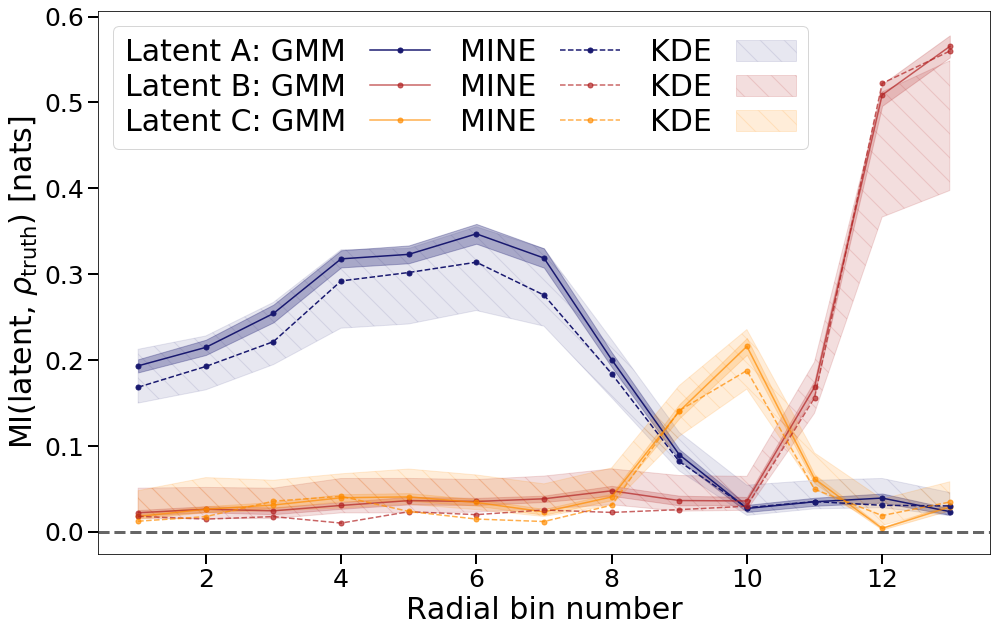

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# latent 0
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)


#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")


# latent 1
ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")


# latent 2
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")



ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine, axis=1), color='midnightblue', marker='o', ls='--', markersize=5, alpha=1, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_one, axis=1), color='firebrick', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_two, axis=1), color='darkorange', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30, ncol=3, labelspacing=0.2, columnspacing=1, markerfirst=False);
#fig.savefig('MI_trend.png', bbox_inches='tight');

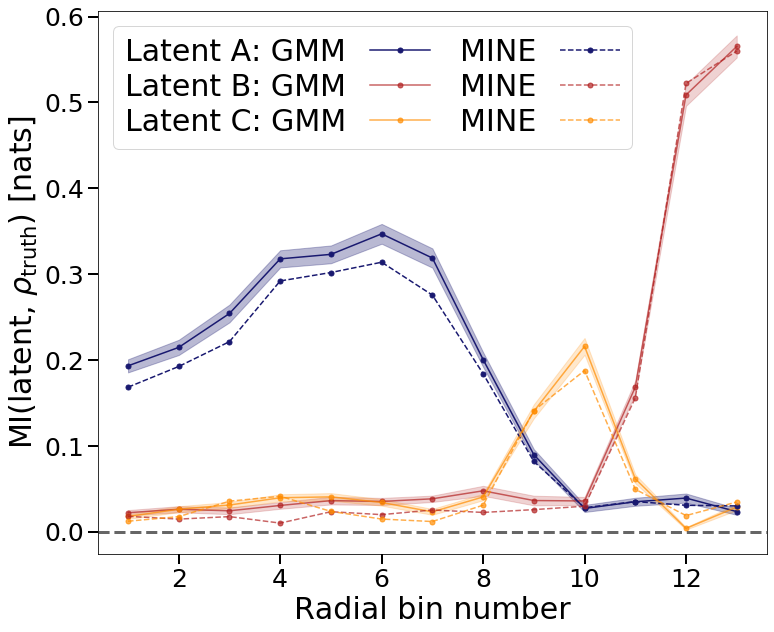

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# latent 0
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)


#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")


# latent 1
ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")


# latent 2
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")



ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine, axis=1), color='midnightblue', marker='o', ls='--', markersize=5, alpha=1, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_one, axis=1), color='firebrick', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_two, axis=1), color='darkorange', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')


ax.set_xlabel('Radial bin number', fontsize=30)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.6)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False);
#fig.savefig('MI_trend.png', bbox_inches='tight');